In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/repos/ProactiveHRI.jl`


In [2]:
Pkg.update()
Pkg.instantiate()

    Updating registry at `~/.julia/registries/General.toml`


  No Changes to `~/repos/ProactiveHRI.jl/Project.toml`
    Updating `~/repos/ProactiveHRI.jl/Manifest.toml`
  [d360d2e6] - ChainRulesCore v1.16.0
  [9e997f8a] - ChangesOfVariables v0.1.8
  [187b0558] - ConstructionBase v1.5.3
  [8bb1440f] + DelimitedFiles v1.9.1
  [3587e190] - InverseFunctions v0.1.11
  [69de0a69] ↑ Parsers v2.7.1 ⇒ v2.7.2
  [1986cc42] ↑ Unitful v1.15.0 ⇒ v1.16.0
  [e33a78d0] + Hwloc_jll v2.9.2+0
⌅ [9cc047cb] ↑ Ipopt_jll v300.1400.400+0 ⇒ v300.1400.1300+0
⌅ [d7ed1dd3] ↑ MUMPS_seq_jll v5.4.1+0 ⇒ v500.600.0+0
⌅ [656ef2d0] ↑ OpenBLAS32_jll v0.3.17+0 ⇒ v0.3.21+0
⌅ [319450e9] + SPRAL_jll v2023.3.29+0
  [44cfe95a] ↑ Pkg v1.8.0 ⇒ v1.9.2
  [10745b16] ~ Statistics ⇒ v1.9.0
  [fa267f1f] ↑ TOML v1.0.0 ⇒ v1.0.3
  [a4e569a6] ↓ Tar v1.10.1 ⇒ v1.10.0
  [e66e0078] ↑ CompilerSupportLibraries_jll v1.0.1+0 ⇒ v1.0.5+0
  [c8ffd9c3] ↑ MbedTLS_jll v2.28.0+0 ⇒ v2.28.2+0
  [14a3606d] ↑ MozillaCACerts_jll v2022.2.1 ⇒ v2022.10.11
  [4536629a] ↑ OpenBLAS_jll v0.3.20+0 ⇒ v0.3.21+4
  [efcefdf7] ↑ P

Precompiling project...


  ✓ ProactiveHRI
  1 dependency successfully precompiled in 9 seconds. 191 already precompiled.
  1 dependency had warnings during precompilation:
┌ ProactiveHRI [07f2525b-7579-49cc-b9c9-14ef6f703e75]
│  WARNING: Method definition (::Type{ProactiveHRI.PlannerHyperparameters{T}})() where {T} in module ProactiveHRI at /home/trajopt/.julia/packages/Parameters/MK0O4/src/Parameters.jl:491 overwritten on the same line (check for duplicate calls to `include`).
│    ** incremental compilation may be fatally broken for this module **
│  
│  WARNING: Method definition kwcall(Any, Type{ProactiveHRI.PlannerHyperparameters{T}}) where {T} in module ProactiveHRI at /home/trajopt/.julia/packages/Parameters/MK0O4/src/Parameters.jl:491 overwritten on the same line (check for duplicate calls to `include`).
│    ** incremental compilation may be fatally broken for this module **
│  
│  WARNING: Method definition (::Type{ProactiveHRI.PlannerHyperparameters{T}})(Any, Any, Any, Any, Any, Any, Any, Any, Any, 

In [3]:
include("dynamics.jl")
include("planner.jl")
include("planner_utils.jl")
include("utils.jl")
include("plotting.jl")
include("mpc.jl")
include("sim.jl")

Sim (generic function with 1 method)

### Interaction planner

In [4]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 1.0]) 
Qt = diagm([10.; 10.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [5]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi]
human_goal_state = [0.; 0.; pi]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# 
# ip = InteractionPlanner(human_hps, 
#                         robot_hps,
#                         human_initial_state,
#                         robot_initial_state,
#                         human_goal_state,
#                         robot_goal_state,
#                         solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [6]:
incon_problem, xs, us = @time solve(ip.ego_planner.incon, iterations=10, verbose=false, keep_history=false)
incon_problem, xs, us = @time solve(ip.other_planner.incon, iterations=10, verbose=false, keep_history=false);



  0.442680 seconds (654.87 k allocations: 53.524 MiB, 7.15% gc time, 72.39% compilation time)


  0.117992 seconds (390.85 k allocations: 34.501 MiB, 24.24% gc time)


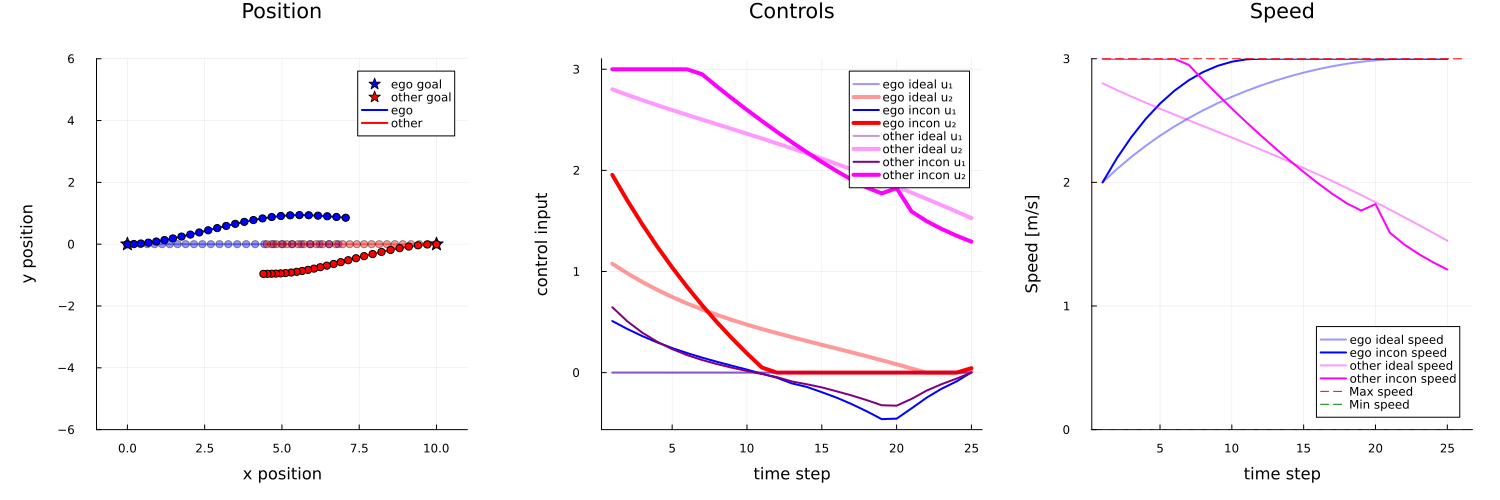

In [7]:
plot_solve_solution(ip, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Iterated Best Response

In [8]:
@time ibr(ip, 3, "ego")

  0.054873 seconds (252.39 k allocations: 21.762 MiB)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


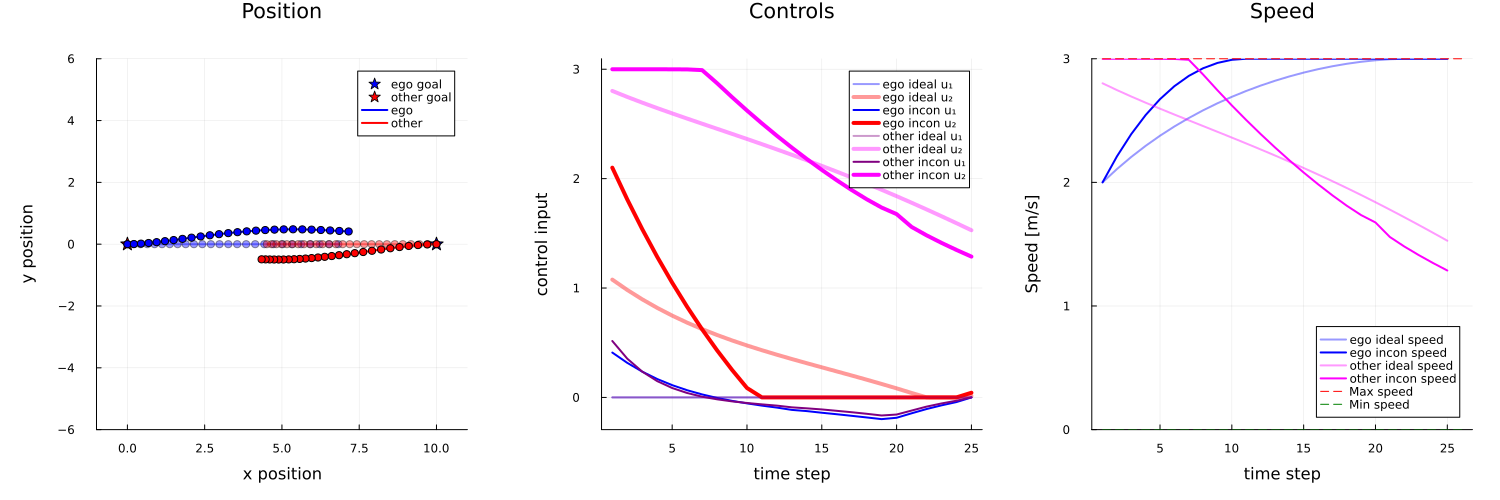

In [9]:
plot_solve_solution(ip, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Animation

┌ Info: Saved animation to /tmp/jl_6hcxMJIpkZ.gif
└ @ Plots /home/trajopt/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_6hcxMJIpkZ.gif")
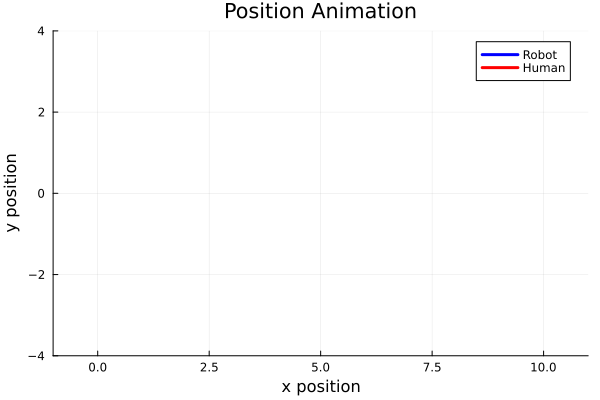

In [10]:
animation(ip, pos_xlims=[-1, 11], pos_ylims=[-4, 4])

Int64

┌ Info: Saved animation to /tmp/jl_6ZWnyVwX2n.gif
└ @ Plots /home/trajopt/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_6ZWnyVwX2n.gif")
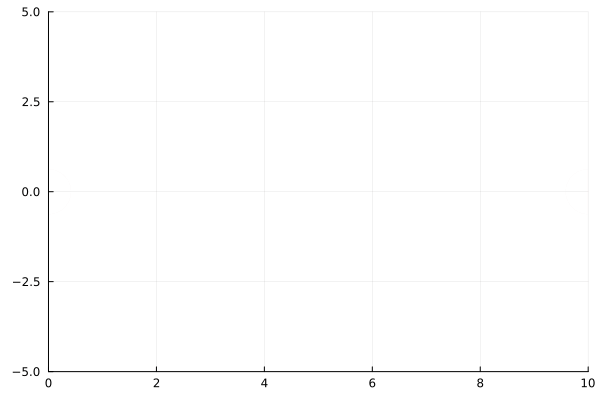

In [11]:
avoidance_animation(ip, pos_xlims=[0, 10], pos_ylims=[-5, 5])

# MPC Controller Simulation
*At the moment it is a known issue that the sim breaks if the dynamics classes used are different between the different InteractionPlanner models, will be fixed

In [12]:
include("sim.jl")
include("mpc.jl")
using AngleBetweenVectors

In [13]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [2 * pi, 2.])
# human = Unicycle(dt, velocity_max, [0.5, 3.])
human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
#SingleIntegratorPolar2D
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
# unicycle
# Q = diagm([0.0; 0.0; 0.])
# R = diagm([1.0; .1]) 
# Qt = diagm([10.; 10.; 0.])
# dynamicalyl extended unicycle
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.1
collision_slack = 250.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [14]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [30.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi; 2]
human_goal_state = [-20.; 0.; pi; 2]

solver = "ECOS"

robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [15]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [3 * pi / 2, 2.])
human = Unicycle(dt, velocity_max, [0.5, 3.])
human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
#SingleIntegratorPolar2D
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
# unicycle
# Q = diagm([0.0; 0.0; 0.])
# R = diagm([1.0; .1]) 
# Qt = diagm([10.; 10.; 0.])
# dynamicalyl extended unicycle
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.1
collision_slack = 250.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [16]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [30.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi; 2]
human_goal_state = [-20.; 0.; pi; 2]

solver = "ECOS"

human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [17]:
robot_path, robot_controls, human_path, human_controls = Sim(robot_ip, human_ip, 75, leader="ego")

([2.305600920595421e-10 0.0 0.0 2.0000000005567777; 0.214999997529204 1.421499893435805e-10 2.987299975437347e-10 2.2999999475333377; … ; 21.692042741801348 0.16577421704983455 -0.019909280054604028 2.9999745090033594; 21.991980370954664 0.1598018856919936 -0.019901895245670674 2.9999835820704317], [0.0 2.999999529309405; 0.3893075995721506 2.99996883796669; … ; -0.00017399850690510185 -0.00048772778624705686; 7.384814330425697e-5 -7.345570356973563e-5], [10.000000000062816 -3.497689645821138e-10 3.141592653551089 1.9999999949137537; 9.785000029703795 4.1499642435197504e-10 3.1415887014566 2.2999994197897697; … ; -11.69302302203996 -0.16671000237049488 3.1215117252465463 2.9999940352869476; -11.99296221897403 -0.16068613521118397 3.121519374396883 2.999999799725502], [-3.9521398721738125e-5 2.9999942574644964; 0.3594926571891543 2.9999984604631527; … ; 8.402572750126622e-5 -8.059063413781587e-5; 7.64914491768365e-5 5.56159494792051e-5])

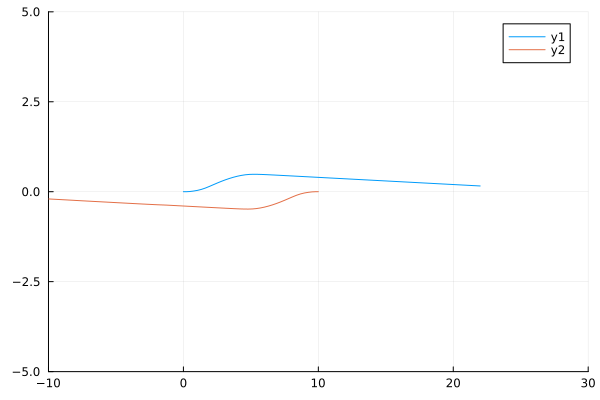

In [18]:
plt = plot(robot_path[:,1], robot_path[:,2], xlims=[-10, 30], ylims=[-5, 5])
plot!(plt, human_path[:,1], human_path[:,2])

┌ Info: Saved animation to /tmp/jl_k5Mrox4DYf.gif
└ @ Plots /home/trajopt/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_k5Mrox4DYf.gif")
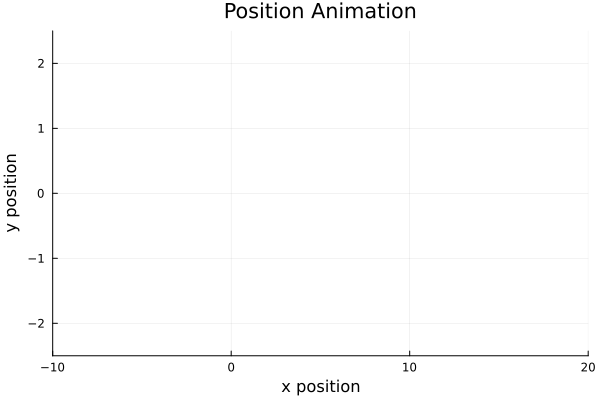

In [19]:
animation(robot_path, human_path, pos_xlims=[-10, 20], pos_ylims=[-2.5, 2.5])

# Summary Plots

### Setup the planner

In [20]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 0.0]) 
Qt = diagm([10.; 10.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [21]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi]
human_goal_state = [0.; 0.; pi]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [22]:
incon_problem, xs, us = @time solve(ip.ego_planner.incon, iterations=10, verbose=false, keep_history=false)
incon_problem, xs, us = @time solve(ip.other_planner.incon, iterations=10, verbose=false, keep_history=false);

  0.123645 seconds (422.13 k allocations: 37.591 MiB, 19.23% gc time)


  0.092008 seconds (389.93 k allocations: 34.330 MiB)


In [23]:
saved_data_test = ibr_save(ip, 3, "ego")

(SaveData
  previous_ips: Array{InteractionPlanner}((3,))
, [[-5.84358850152726e-10 -6.680323935741418e-10 -3.0031737719239e-10 1.9999999996060958; 0.20681081849368305 0.004560214950930622 0.04359546956225507 2.13754512185005; … ; 6.643662213003601 0.6451048797333382 -0.08300116979752147 2.9999980713138434; 6.942880081868442 0.6202121549967533 -0.08284602611677387 3.004621359623642], [1.855425612612705e-10 -2.246189752872087e-11 -3.2478802765309317e-10 2.0000000010782126; 0.20759738428683863 0.004249186687295087 0.04041853619037213 2.1530931797335353; … ; 6.719959846678065 0.5082264832918721 -0.06794354467097567 2.999998980658651; 7.019527275807962 0.4878411622867435 -0.0679399186701304 3.004524932266363], [-8.172688413185182e-10 -6.625315986996738e-10 -3.8216831326365176e-10 2.0000000001083293; 0.20826500400425424 0.0038736607337218217 0.03669129020450409 2.1662446572652105; … ; 6.771282213492248 0.403131956189976 -0.054917902465520925 2.9999981351081826; 7.0710768021652735 0.38665113

In [24]:
plot_example = plot_solve_solution(saved_data_test, scatter=false, show_speed=true, show_control=true)

MethodError: MethodError: no method matching plot_solve_solution(::Tuple{SaveData, Vararg{Vector{Matrix{Float64}}, 4}}; scatter::Bool, show_speed::Bool, show_control::Bool)

Closest candidates are:
  plot_solve_solution(!Matched::Problem; pos_xlims, pos_ylims) got unsupported keyword arguments "scatter", "show_speed", "show_control"
   @ Main ~/repos/ProactiveHRI.jl/src/plotting.jl:7
  plot_solve_solution(!Matched::InteractionPlanner; pos_xlims, pos_ylims) got unsupported keyword arguments "scatter", "show_speed", "show_control"
   @ Main ~/repos/ProactiveHRI.jl/src/plotting.jl:38
  plot_solve_solution(!Matched::SaveData; pos_xlims, pos_ylims, scatter, show_speed, show_control)
   @ Main ~/repos/ProactiveHRI.jl/src/plotting.jl:126


In [ ]:
function plot_solve_solution(problem::SaveData, second_problem::SaveData,show_theta::Bool; pos_xlims=[-1,11], pos_ylims=[-6, 6], scatter=true::Bool, show_speed=true::Bool, show_control=true::Bool)

    l = @layout [a b c d e] 
    width=2000
    height=400
    alpha_plot = 0.7
    linewidth = 2
    markersize = 2
    markersize_large = 7
    ego_color = :blue
    other_color = :red

    global iterations = length(problem.previous_ips)

    alpha_ratio = 1 / (iterations + 1)
    N = problem.previous_ips[1].ego_planner.ideal.hps.time_horizon

    ego_goal_state = problem.previous_ips[1].ego_planner.ideal.opt_params.goal_state
    other_goal_state = problem.previous_ips[1].other_planner.ideal.opt_params.goal_state

    ego_dynamics = problem.previous_ips[1].ego_planner.ideal.hps.dynamics       # use first ip arbitrarily, any iteration will give the same values for these entries
    other_dynamics = problem.previous_ips[1].other_planner.ideal.hps.dynamics

    global ego_ctrl_dim = 2
    global other_ctrl_dim = 2

    # plotting position trajectory

    plot_traj = plot(size=(height, height), xlabel="x position", ylabel="y position", title="Position", margin=10mm, ylims=pos_ylims, xlims=pos_xlims, aspect_ratio=:equal)
    scatter!(ego_goal_state[1:1], ego_goal_state[2:2], marker=:star, markersize=markersize_large, color=ego_color, label="ego goal")
    scatter!(plot_traj, other_goal_state[1:1], other_goal_state[2:2], marker=:star, markersize=markersize_large, color=other_color, label="other goal")

    plot!(plot_traj, value.(problem.previous_ips[end].ego_planner.incon.model[:x])[:,1], value.(problem.previous_ips[end].ego_planner.incon.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="", alpha=alpha_plot)

    plot!(plot_traj, value.(problem.previous_ips[end].other_planner.incon.model[:x])[:,1], value.(problem.previous_ips[end].other_planner.incon.model[:x])[:,2], color=other_color, linewidth=linewidth, label="", alpha=alpha_plot)


    plot!(plot_traj, value.(second_problem.previous_ips[end].ego_planner.incon.model[:x])[:,1], value.(second_problem.previous_ips[end].ego_planner.incon.model[:x])[:,2], color=:green, linewidth=linewidth, label="", alpha=alpha_plot)

    plot!(plot_traj, value.(second_problem.previous_ips[end].other_planner.incon.model[:x])[:,1], value.(second_problem.previous_ips[end].other_planner.incon.model[:x])[:,2], color=:magenta, linewidth=linewidth, label="", alpha=alpha_plot)

    if scatter
        scatter!(plot_traj, value.(problem.previous_ips[end].ego_planner.ideal.model[:x])[:,1], value.(problem.previous_ips[end].ego_planner.ideal.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="", alpha=alpha_plot)

        scatter!(plot_traj, value.(problem.previous_ips[end].other_planner.ideal.model[:x])[:,1], value.(problem.previous_ips[end].other_planner.ideal.model[:x])[:,2], color=other_color, linewidth=linewidth, label="", alpha=alpha_plot)

        scatter!(plot_traj, value.(second_problem.previous_ips[end].ego_planner.ideal.model[:x])[:,1], value.(second_problem.previous_ips[end].ego_planner.ideal.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="", alpha=alpha_plot)

        scatter!(plot_traj, value.(second_problem.previous_ips[end].other_planner.ideal.model[:x])[:,1], value.(second_problem.previous_ips[end].other_planner.ideal.model[:x])[:,2], color=other_color, linewidth=linewidth, label="", alpha=alpha_plot)
    end
    # plotting speed/control

    # speed parameters
    max_speed = maximum([problem.previous_ips[1].ego_planner.ideal.hps.dynamics.velocity_max, problem.previous_ips[1].other_planner.ideal.hps.dynamics.velocity_max])
    ego_max_speed = problem.previous_ips[1].ego_planner.ideal.hps.dynamics.velocity_max
    other_max_speed = problem.previous_ips[1].other_planner.ideal.hps.dynamics.velocity_max

    # control parameters
    ego_ctrl_dim = problem.previous_ips[1].ego_planner.ideal.hps.dynamics.ctrl_dim
    other_ctrl_dim = problem.previous_ips[1].other_planner.ideal.hps.dynamics.ctrl_dim

    ego_max_ctrl = maximum(problem.previous_ips[1].ego_planner.ideal.hps.dynamics.control_max)
    ego_min_ctrl = minimum(problem.previous_ips[1].ego_planner.ideal.hps.dynamics.control_min)
    other_max_ctrl = maximum(problem.previous_ips[1].other_planner.ideal.hps.dynamics.control_max)
    other_min_ctrl = minimum(problem.previous_ips[1].other_planner.ideal.hps.dynamics.control_min)

    plot_theta = plot(size=(height, height), xlabel="time step", ylabel="abs(Theta)", title="Theta vs. time", margin=10mm, legend=:bottomright)
    plot_ctrl = plot(size=(height, height), xlabel="time step", ylabel="input magnitude", title="Control", margin=10mm)

    # angle plotting
    robot_xs_mu_09 = vector_of_vectors_to_matrix(problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_states)
    human_xs_mu_09 = vector_of_vectors_to_matrix(problem.previous_ips[iterations].other_planner.incon.opt_params.previous_states)
    robot_xs_mu_11 = vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_states)
    human_xs_mu_11 = vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].other_planner.incon.opt_params.previous_states)
    plot!(plot_theta, robot_xs_mu_09[:,3:3])
    plot!(plot_theta, human_xs_mu_09[:,3:3])
    plot!(plot_theta, robot_xs_mu_11[:,3:3])
    plot!(plot_theta, human_xs_mu_11[:,3:3])

        # ctrl plotting
    plot!(plot_ctrl, 1:N, maximum([ego_max_ctrl, other_max_ctrl]) * ones(Float64, N), linestyle=:dash, linewith=linewidth,  color=:green, label="Control Limits")
    plot!(plot_ctrl, 1:N, minimum([ego_min_ctrl, other_min_ctrl]) * ones(Float64, N), linestyle=:dash, linewith=linewidth,  color=:green, label="")   
        # ego plot
    for j in 1:ego_ctrl_dim
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_controls)[:, j], label="", color=RGB(1 - (1 / ego_ctrl_dim) * j, 0., (1 / ego_ctrl_dim) * j), linewidth=linewidth, alpha=(i * alpha_ratio))
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_controls)[:, j], label="", color=RGB(1 - (1 / ego_ctrl_dim) * j, 0., (1 / ego_ctrl_dim) * j), linewidth=linewidth, alpha=(i * alpha_ratio))
    end 
        # other plot
    for k in 1:other_ctrl_dim
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(problem.previous_ips[iterations].other_planner.incon.opt_params.previous_controls)[:, k], label="", color=RGB((1 / other_ctrl_dim) * k, 1 - (1 / other_ctrl_dim) * k, 0.), linewidth=linewidth, alpha=(i * alpha_ratio))
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].other_planner.incon.opt_params.previous_controls)[:, k], label="", color=RGB((1 / other_ctrl_dim) * k, 1 - (1 / other_ctrl_dim) * k, 0.), linewidth=linewidth, alpha=(i * alpha_ratio))
    end 


    slack_violation = Vector{Float64}(undef, iterations)

    for i in 1:iterations
        slack_violation[i] = value(problem.previous_ips[i].ego_planner.incon.model[:ϵ])
    end

    plot_slack_violation = plot(size=(height, height), xlabel="Iteration", ylabel="ϵ (slack value)", title="Slack (collision) Violation", margin=10mm)

    plot!(plot_slack_violation, 1:iterations, slack_violation, color=:black, label="Slack")

    # plotting inconvenience value over iterations

    incon_budget = problem.previous_ips[1].ego_planner.incon.hps.inconvenience_ratio
    inconvenience_ego = Vector{Float64}(undef, iterations)
    inconvenience_other = Vector{Float64}(undef, iterations)

    ideal_incon_ego = compute_convenience_value(ego_dynamics, matrix_to_vector_of_vectors(value.(problem.previous_ips[1].ego_planner.ideal.model[:x])), matrix_to_vector_of_vectors(value.(problem.previous_ips[1].ego_planner.ideal.model[:u])), ego_goal_state, problem.previous_ips[1].ego_planner.incon.hps.inconvenience_weights)

    ideal_incon_other = compute_convenience_value(other_dynamics, matrix_to_vector_of_vectors(value.(problem.previous_ips[1].other_planner.ideal.model[:x])), matrix_to_vector_of_vectors(value.(problem.previous_ips[1].other_planner.ideal.model[:u])), other_goal_state, problem.previous_ips[1].other_planner.incon.hps.inconvenience_weights)

    for i in 1:iterations
        inconvenience_ego[i] = compute_convenience_value(ego_dynamics, problem.previous_ips[i].ego_planner.incon.opt_params.previous_states, problem.previous_ips[i].ego_planner.incon.opt_params.previous_controls, ego_goal_state, problem.previous_ips[1].ego_planner.incon.hps.inconvenience_weights)
        
        inconvenience_other[i] = compute_convenience_value(other_dynamics, problem.previous_ips[i].other_planner.incon.opt_params.previous_states, problem.previous_ips[i].other_planner.incon.opt_params.previous_controls, other_goal_state, problem.previous_ips[1].other_planner.incon.hps.inconvenience_weights)
    end

    inconvenience_ego ./= ideal_incon_ego
    inconvenience_other ./= ideal_incon_other 

    plot_incon = plot(size=(height, height), xlabel="Iteration", ylabel="Inconvenience", title="Agent Inconvenience", margin=10mm)
    plot!(plot_incon, 1:iterations, ones(iterations), linestyle=:dash, linewith=linewidth, color=:green, label="Ideal Incon")
    plot!(plot_incon, 1:iterations, ones(iterations) .+ incon_budget, linestyle=:dash, linewith=linewidth, color=:black, label="Incon Budget")
    plot!(plot_incon, 1:iterations, inconvenience_ego, color=ego_color, linewidth=linewidth, label="Ego Incon")
    plot!(plot_incon, 1:iterations, inconvenience_other, color=other_color, linewidth=linewidth, label="Other Incon")

    plot(plot_traj, plot_theta, plot_ctrl, plot_slack_violation, plot_incon, layout=l, size=(width, height))
end
